# Classify using convolutional neural network (CNN)

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, Flatten
from tensorflow.keras import activations
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler

import numpy as np
from os.path import join
from sklearn.model_selection import train_test_split

2025-01-13 18:35:58.615272: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 18:35:58.802999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736789758.871189  139184 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736789758.893195  139184 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 18:35:59.076274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
input_width = 64
input_height = 64
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)
output_classes = 7

In [13]:
#model = Sequential()
#model.add(Dense(1024, activation='relu', input_dim=input_dim, kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))
#model.add(Dense(128, activation='relu', input_dim=input_dim, kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))
#model.add(Dense(16, activation='relu', input_dim=input_dim, kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))
#model.add(Dense(7, activation='softmax', kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))
#model.summary()



model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(output_classes, activation='softmax'))

In [14]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Define loss function, optimizer, and metrics to track during training
model.compile(
    optimizer='adam', # .. or optimizers.SGD(lr=0.01)
    loss='sparse_categorical_crossentropy', # .. or losses.sparse_categorical_crossentropy
    metrics=['acc'] # .. or metrics.sparse_categorical_accuracy
)


In [15]:
DATA_PATH = 'data'

with np.load(join(DATA_PATH, 'processed_data.npz')) as data:
    data_dict=dict(data.items())
X = data_dict['X']
y = data_dict['y']

In [16]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)
print('The training dataset has {} entries, the test dataset {}.'.format(
    len(X_train), len(X_test)))

The training dataset has 11522 entries, the test dataset 3841.


In [41]:
import random

# Get a smaller random sample 
NUM_SAMPLES = 2000
idx = random.sample(range(len(X_train)-1), NUM_SAMPLES)
X_train_rnd = X_train[idx]
y_train_rnd = y_train[idx]

In [42]:
# Rescale train and validation data
scaler = StandardScaler()
#X_train_preprocessed = scaler.fit_transform(X_train_rnd.reshape([-1, input_dim]).astype('float'))
#X_test_preprocessed = scaler.transform(X_test.reshape([-1,input_dim]).astype('float'))
X_train_preprocessed = X_train_rnd.reshape([-1, input_width, input_height, input_depth]).astype('uint8')
X_test_preprocessed = X_test.reshape([-1, input_width, input_height, input_depth]).astype('uint8')
y_train_preprocessed = np.unique(y_train_rnd, return_inverse=True)[1]
y_test_preprocessed = np.unique(y_test, return_inverse=True)[1]

print('Train:', X_train_preprocessed.shape)
print('Test:', X_test_preprocessed.shape)

Train: (2000, 64, 64, 3)
Test: (3841, 64, 64, 3)


In [43]:
from PIL import Image
data = X_train_preprocessed[1]
img = Image.fromarray(data, 'RGB')
img.show()

In [44]:
%%time
# Fit model
history = model.fit(
    x=X_train_preprocessed, y=y_train_preprocessed,
    validation_split=0.2, batch_size=32, epochs=10,
    shuffle=True # Shuffle training samples
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - acc: 0.1943 - loss: 2.9385 - val_acc: 0.1575 - val_loss: 1.9287
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - acc: 0.1768 - loss: 1.9361 - val_acc: 0.1600 - val_loss: 1.9301
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - acc: 0.1898 - loss: 1.9082 - val_acc: 0.1650 - val_loss: 1.9690
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - acc: 0.2009 - loss: 1.8785 - val_acc: 0.1600 - val_loss: 1.9814
Epoch 5/10
 3/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.1788 - loss: 1.8898

KeyboardInterrupt: 

NameError: name 'history' is not defined

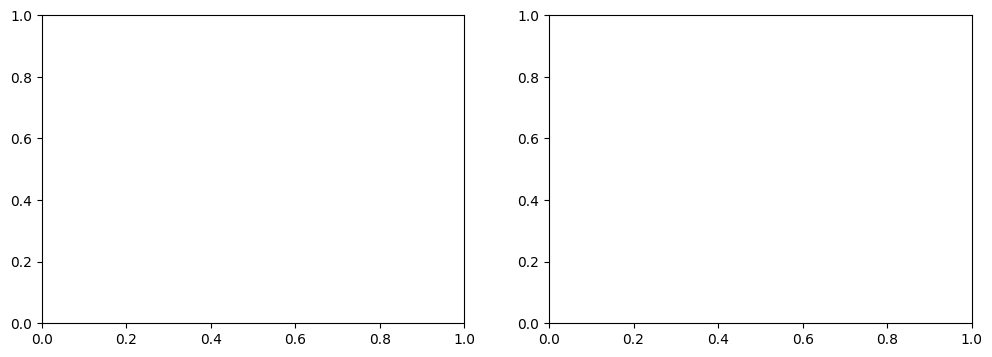

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['acc'], label='train acc')
ax2.plot(history.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()


In [ ]:
(test_loss, test_accuracy) = model.evaluate(X_test_preprocessed, y_test_preprocessed, batch_size=32)

print('Test loss: {:.2f}'.format(test_loss)) # around 0.19
print('Test accuracy: {:.2f}%'.format(100*test_accuracy)) # around 95%
